# Статистический анализ данных #

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
  - абонентская плата отсутствует;
  - стоимость одной минуты поездки — `8` рублей;
  - стоимость старта (начала поездки) — `50` рублей;
- с подпиской Ultra
  - абонентская плата — `199` рублей в месяц;
  - стоимость одной минуты поездки — `6` рублей;
  - стоимость старта — бесплатно.


**Цель исследования**

Проанализировать данные и проверить такие гипотезы как:
 1. Тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки.
 2. Не превышает ли среднее расстояние 3130 метров за одну поездку, у пользователей с подпиской, т.к. оптимальное с точки зрения износа самоката - 3130 метров. 
 3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
 4. Какой тест понадобится для проверки гипотезы, чтобы узнать, снизилось ли количество обращений в техподдержку после обновления сервера, с которым взаимодействует мобильное приложение?
 
 **Ход исследования**

Данные о пользователях сервиса получу из файла `/datasets/users_go.csv`, данные о поездках из файла `/datasets/rides_go.csv` и данные о подписках из файла `/datasets/subscriptions_go.csv`. О качестве данных в файлах пока не известно и по этой причине, перед проведением исследований, необходимо провести обзор данных.

Я проверю данные на пропущенные значения, ошибки и дублированные значения. На этапе предобработки данных, я поищу возможность исправить все ошибки в данных, которые могут привести к искажению конечного результата исследования. После чего, создам необходимые столбцы, исправлю формат некоторых столбцов в датафреймах и приступлю к проведению исследовательского анализа.

Моё исследование будет проходить через следующие этапы:
- Обзор данных;
- Предобработка данных;
- Описание и визуализация:
  - частоты встречаемости городов;
  - соотношения пользователей с подпиской и без подписки;
  - возраста пользователей;
  - расстояния, преодоленное пользователем за одну поездку;
  - продолжительности поездок.
- Объединение данных;
- Подсчёт выручки:
- Проверка гипотез.



# Начало исследования #

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import (
    ttest_ind, 
    ttest_1samp
)

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
display(users.head())
display(rides.head())
display(subscriptions)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [4]:
# Количество значений
print("users: ", users.shape[0])
print("rides: ", rides.shape[0])
print("subscriptions: ", subscriptions.shape[0])

users:  1565
rides:  18068
subscriptions:  2


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


#### Шаг 2. Предобработка данных

In [8]:
# Меняем формат даты на date датафрейма rides 
rides['date'] = pd.to_datetime(rides['date'])

# Добавление столбца месяца в датафрейм rides
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [9]:
# Проверяем данные из датафрейма rides на максимальные и минимальные 
# значения, то есть на разные года.

# Минимальное значение
min_date = rides['date'].min()
# Максимальное значение
max_date = rides['date'].max()

print('Минимальное: ', min_date)
print('Максимальное: ', max_date)

Минимальное:  2021-01-01 00:00:00
Максимальное:  2021-12-30 00:00:00


In [10]:
# Получаем годы из найденных дат
min_year = min_date.year
max_year = max_date.year

# Проверяем, есть ли разные годы
if min_year != max_year:
    print("Данные содержат значения разных годов.")
else:
    print("Данные содержат значения только за один год.")


Данные содержат значения только за один год.


In [11]:
# Проверка на пропущенные значения в датафрейме users
check_users_isna = users.isna().sum().sort_values(ascending=False)
check_users_isna

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
# Проверка на пропущенные значения в датафрейме rides
check_rides_isna = rides.isna().sum().sort_values(ascending=False)
check_rides_isna

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [13]:
# Проверка на пропущенные значения в датафрейме subscriptions
check_subscriptions_isna = subscriptions.isna().sum().sort_values(ascending=False)
check_subscriptions_isna

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Проверяем на дубликаты**

In [14]:
# Сортируем данные датафрейма users по столбцу user_id
sorted_users = users.sort_values(by='user_id')

# Найти дубликаты только в столбце "user_id"
duplicate_user_ids = sorted_users['user_id'].duplicated(keep=False)

# Вывести строки с дубликатами user_id
display(sorted_users[duplicate_user_ids].head())

# Посчитать количество дублированных данных
duplicate_counts = users.loc[duplicate_user_ids, 'user_id'].value_counts()

# Вывести результат
duplicate_counts.head()

,user_id,name,age,city,subscription_type
1535,16,Амалия,27,Краснодар,ultra
15,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra


72      2
422     2
136     2
635     2
1237    2
Name: user_id, dtype: int64

In [15]:
# Удалить дублированные данные, оставить только по одному
unique_users = users.drop_duplicates(subset='user_id', keep='first', inplace=True)

# Посчитать количество дублированных данных
duplicate_counts_2 = users.loc[duplicate_user_ids, 'user_id'].value_counts()

# Вывести результат
display(duplicate_counts_2.head())

users.info()

127     1
293     1
829     1
635     1
1237    1
Name: user_id, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


**Описание исходных данных:**

Исходные данные файла `/datasets/users_go.csv` представляет собой набор информации о пользователях, их уникальных ID номерах, именах, возраста, города и типа подписки. 

Исходные данные файла `/datasets/rides_go.csv` представляет собой набор информации о поездках пользователей, их уникальных ID номерах, дистанции и продолжительность сессии (в минутах), а также о дате поездки.

Исходные данные файла `/datasets/subscriptions_go.csv` представляет собой набор информации о подписках, о типах подписок, цен за минуту для каждого типа, о ценах стартовой цены и цены для каждого типа подписки. 

**Качество данных**

Исходные данные нуждались в предобработке перед анализом. Были обнаружены дублированные данные, нет явных признаков некорректных данных.


#### Шаг 3. Исследовательский анализ данных

Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:

3.1 частота встречаемости городов;



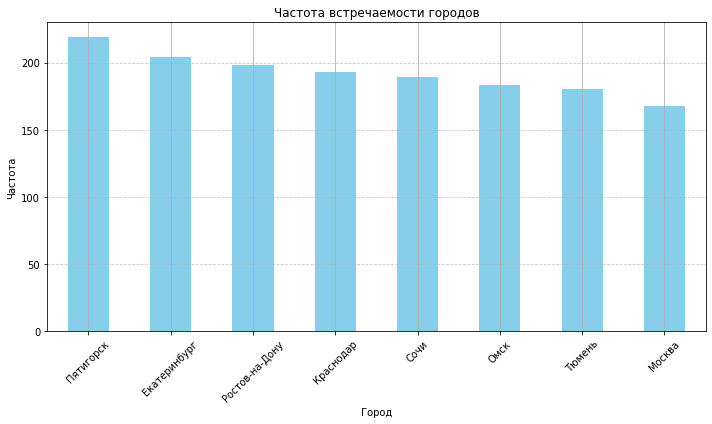

In [16]:
# Подсчет частоты встречаемости городов
city_counts = users['city'].value_counts()

# Визуализация частоты встречаемости городов
plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar', color='skyblue')
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(True)
plt.show()

**Частота встречаемости городов из данных**

Список топ-3 часто встречаемых городов, в порядке убывания:
1. Пятгорск;
2. Екатеринбург;
3. Ростов-на-Дону.

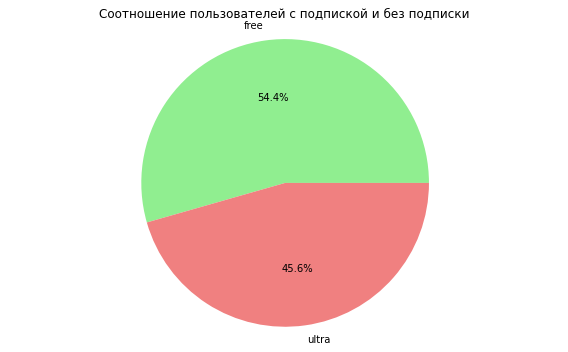

In [17]:
# Подсчет соотношения пользователей с подпиской и без подписки
subscription_counts = users['subscription_type'].value_counts()

# Визуализация соотношения пользователей
plt.figure(figsize=(8, 5))
subscription_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.show()

Соотношение пользователей с подпиской и без подписки:
- 54.4% - `free`
- 45.6% - `ultra`


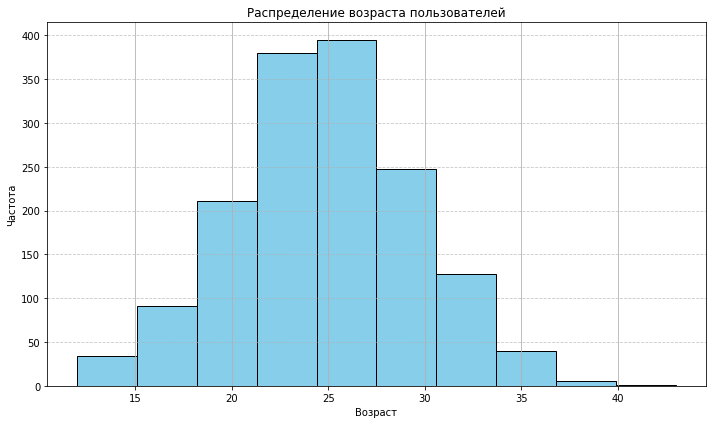

In [18]:
# Визуализация распределения возраста пользователей
plt.figure(figsize=(10, 6))
plt.hist(users['age'], bins=10, color='skyblue', edgecolor='black')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(True)
plt.show()

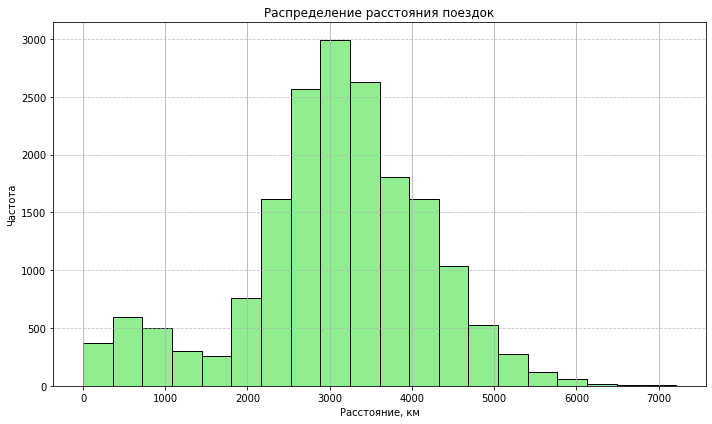

In [19]:
# Визуализация распределения расстояния поездок
plt.figure(figsize=(10, 6))
plt.hist(rides['distance'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние, км')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(True)
plt.show()

Среднее значение частоты расстояния: `3000` км.

In [20]:
# Описание распределения данных о расстоянии поездок
rides_distance_description = rides['distance'].describe()

print("Описание распределения данных о расстоянии поездок:")
rides_distance_description

Описание распределения данных о расстоянии поездок:


count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Исходя из вышуказанных резузльтатов можно сделать следующий вывод:
- Минимальное - `0.855683` 
- Максимальное - `7211.007745`
- Среднее - `3070.659976`
- Основной диапазон, можно указать между первым и третьим картилями - `2543.226360` -> `3776.222735`
- Распределение - `Бимодальное` или двухпиковое

Ниже, диаграмма размаха для расстояния поездок, который отображает аномалии

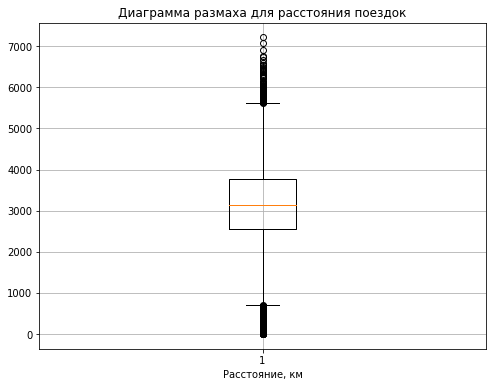

In [21]:
# Создание ящика с усами для расстояния поездок
plt.figure(figsize=(8, 6))
plt.boxplot(rides['distance'])
plt.title('Диаграмма размаха для расстояния поездок')
plt.xlabel('Расстояние, км')
plt.grid(True)
plt.show()

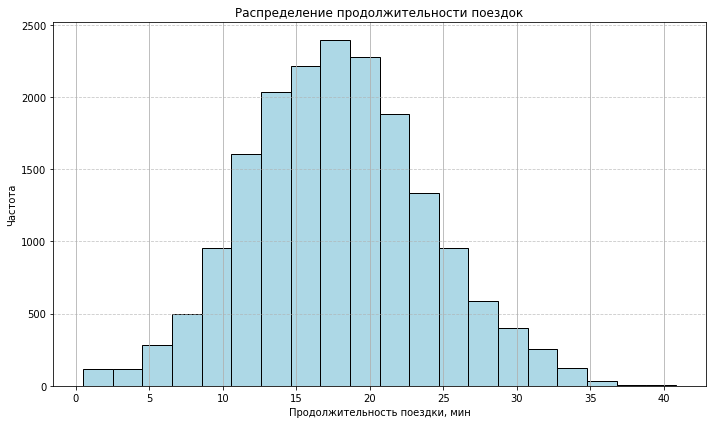

In [22]:
# Визуализация распределения продолжительности поездок
plt.figure(figsize=(10, 6))
plt.hist(rides['duration'], bins=20, color='lightblue', edgecolor='black')
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(True)
plt.show()

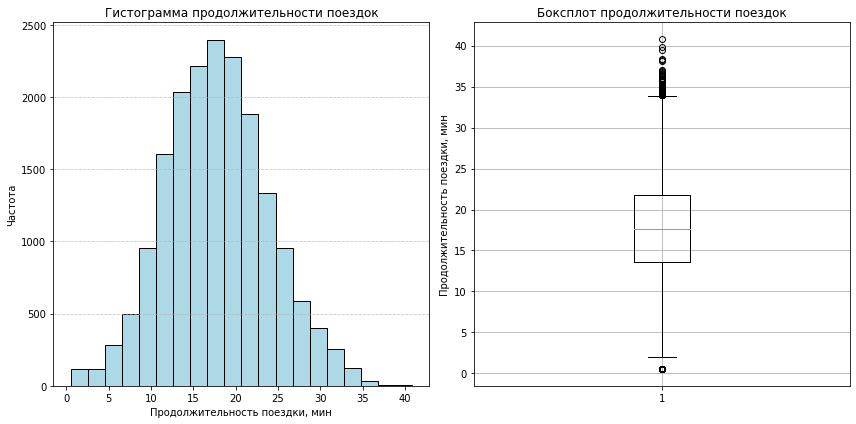

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  
plt.hist(rides['duration'], bins=20, color='lightblue', edgecolor='black')
plt.title('Гистограмма продолжительности поездок')
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.subplot(1, 2, 2)  # Создание графика во второй из двух колонок
plt.boxplot(rides['duration'])
plt.title('Боксплот продолжительности поездок')
plt.ylabel('Продолжительность поездки, мин')

plt.tight_layout()
plt.grid(True)
plt.show()

In [24]:
duration_description = rides['duration'].describe()

print("\nОписание распределения данных о продолжительности поездок:")
duration_description


Описание распределения данных о продолжительности поездок:


count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Исходя из вышуказанных резузльтатов можно сделать следующий вывод:
- Минимальное - `0.500000`
- Максимальное - `40.823963`
- Среднее - `17.805011`
- Основной диапазон, можно указать между первым и третьим картилями - `13.597563` -> `21.724800`
- Распределение - `Нормальное`

Аномалии отображены выше, справа от самой гистограммы распределения поездок по времени


## Шаг 4. Объединение данных

**Проверка размерности датафреймов**

In [25]:
# Проверка размерности датафрейма users
users.shape[0]

1534

In [26]:
# Проверка размерности датафрейма rides
rides.shape[0]

18068

In [27]:
# Проверка размерности датафрейма subscriptions
subscriptions.shape[0]

2

In [28]:
# Объединение датафреймов user и rides методом merge
merged_data = pd.merge(users, rides, on='user_id', how='left')
# Объединение датафреймов merged_data и subscriptions методом merge  
merged_data = pd.merge(merged_data, subscriptions, on='subscription_type', how='left')

# Вывод полученного объединенного датафрейма
merged_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [29]:
# Проверка размерности объединенного файла merged_data
merged_data.shape[0]

18068

Стоит более подробно описать распределение данных: вид распредления, основной диапазон, минимум, максимум, наличие аномалий.

In [30]:
# Создание датафрейма с данными о пользователях без подписки
users_without_subs = merged_data.query("subscription_type == 'free'")

# Создание датафрейма с данными о пользователях с подпиской
users_with_subs = merged_data.query("subscription_type == 'ultra'")

# Вывод первых нескольких строк каждого датафрейма для проверки
print("Данные о пользователях без подписки:")
display(users_without_subs.head())
print()
print("\nДанные о пользователях с подпиской:")
users_with_subs.head()

Данные о пользователях без подписки:


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0




Данные о пользователях с подпиской:


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [31]:
# Проверка размерности объединенного файла о пользователях без подписки
users_without_subs.shape[0]

11568

In [32]:
# Проверка размерности объединенного файла о пользователях с подпиской
users_with_subs.shape[0]

6500

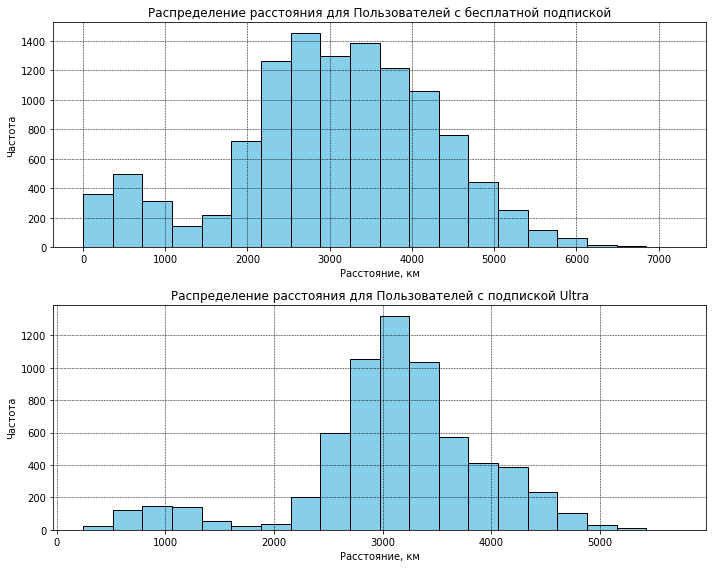

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

categories = {
    'Пользователей с бесплатной подпиской': users_without_subs,
    'Пользователей с подпиской Ultra': users_with_subs
}

for ax, (category, data) in zip(axes, categories.items()):
    ax.hist(data['distance'], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Распределение расстояния для {category}')
    ax.set_xlabel('Расстояние, км')
    ax.set_ylabel('Частота')
    ax.grid(True, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

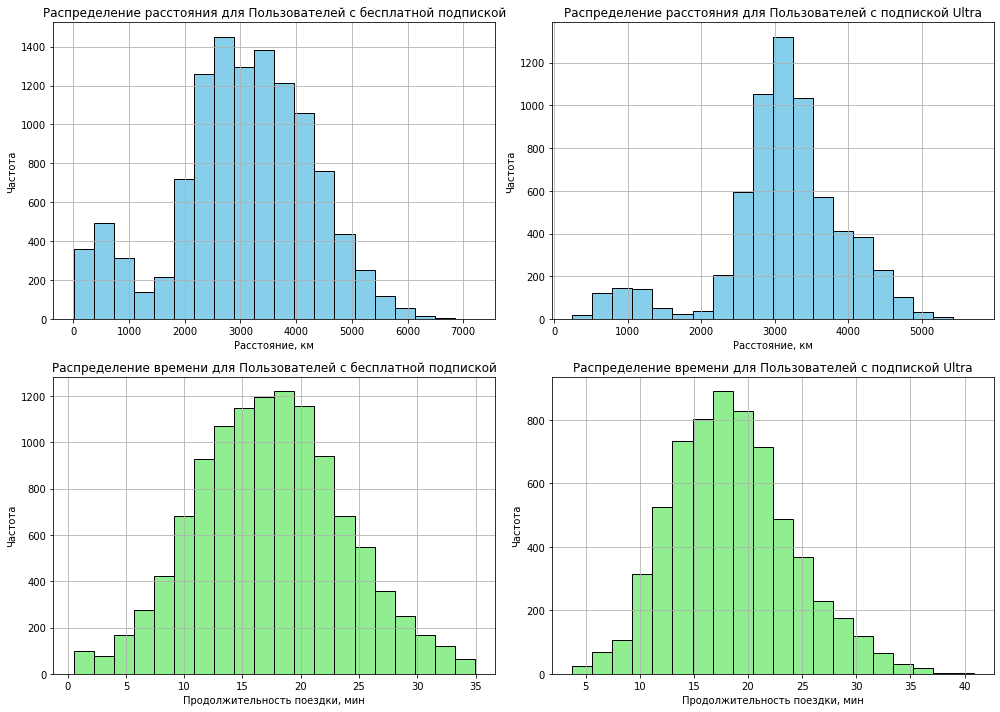

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

categories = {
    'Пользователей с бесплатной подпиской': users_without_subs,
    'Пользователей с подпиской Ultra': users_with_subs
}

for i, (category, data) in enumerate(categories.items()):
    ax1 = axes[0, i]
    ax2 = axes[1, i]
    
    ax1.hist(data['distance'], bins=20, color='skyblue', edgecolor='black')
    ax1.set_title(f'Распределение расстояния для {category}')
    ax1.set_xlabel('Расстояние, км')
    ax1.set_ylabel('Частота')
    ax1.grid(True)
    
    ax2.hist(data['duration'], bins=20, color='lightgreen', edgecolor='black')
    ax2.set_title(f'Распределение времени для {category}')
    ax2.set_xlabel('Продолжительность поездки, мин')
    ax2.set_ylabel('Частота')
    ax2.grid(True)


plt.tight_layout()
plt.show()

#### Шаг 5. Подсчёт выручки

In [35]:
merged_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [36]:
user_trip_count = merged_data.groupby(['user_id']).size().reset_index(name='trip_count')

display(user_trip_count.head())

,user_id,trip_count
0,1,12
1,2,11
2,3,12
3,4,14
4,5,11


In [37]:
merged_data['duration'] = np.ceil(merged_data['duration']).round()

merged_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [38]:
agg_data = merged_data.groupby(['user_id', 'month']).agg({
    'distance': 'sum',        
    'duration': 'sum',        
}).reset_index()

agg_data = pd.merge(user_trip_count, agg_data, on='user_id', how='left')

agg_data.rename(columns={
    'distance': 'total_distance',
    'duration': 'total_duration'
}, inplace=True)

agg_data['total_distance'] = agg_data['total_distance'].apply(lambda x: round(x, 2))
agg_data['total_duration'] = agg_data['total_duration'].apply(lambda x: round(x, 2))

agg_data.head()

,user_id,trip_count,month,total_distance,total_duration
0,1,12,1,7027.51,42.0
1,1,12,4,754.16,7.0
2,1,12,8,6723.47,46.0
3,1,12,10,5809.91,32.0
4,1,12,11,7003.50,56.0


In [39]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [40]:
subscription_info = {
    'free': {'minute_price': 8, 'start_ride_price': 50, 'subscription_fee': 0},
    'ultra': {'minute_price': 6, 'start_ride_price': 0, 'subscription_fee': 199}
}

user_trip_count = pd.merge(agg_data, merged_data[['user_id', 'month', 'subscription_type']], on=['user_id', 'month'])

def calculate_monthly_revenue(row):
    rate_info = subscription_info.get(row['subscription_type'], {})
    return (rate_info.get('start_ride_price', 0) * row['trip_count'] +
            rate_info.get('minute_price', 0) * row['total_duration'] +
            rate_info.get('subscription_fee', 0))

user_trip_count['monthly_revenue'] = user_trip_count.apply(calculate_monthly_revenue, axis=1)

user_trip_count.head()

,user_id,trip_count,month,total_distance,total_duration,subscription_type,monthly_revenue
0,1,12,1,7027.51,42.0,ultra,451.0
1,1,12,1,7027.51,42.0,ultra,451.0
2,1,12,4,754.16,7.0,ultra,241.0
3,1,12,8,6723.47,46.0,ultra,475.0
4,1,12,8,6723.47,46.0,ultra,475.0


In [41]:
columns_to_check_duplicates = ['user_id', 'month']

dupl_user_trip_count = user_trip_count.duplicated(subset=columns_to_check_duplicates, keep=False)

duplicated_rows = user_trip_count[dupl_user_trip_count]

df_no_duplicates = user_trip_count.drop_duplicates(subset=columns_to_check_duplicates, keep='first', inplace=True)

print("Строки с дубликатами:")
display(duplicated_rows.head())

Строки с дубликатами:


,user_id,trip_count,month,total_distance,total_duration,subscription_type,monthly_revenue
0,1,12,1,7027.51,42.0,ultra,451.0
1,1,12,1,7027.51,42.0,ultra,451.0
3,1,12,8,6723.47,46.0,ultra,475.0
4,1,12,8,6723.47,46.0,ultra,475.0
5,1,12,10,5809.91,32.0,ultra,391.0


In [42]:
user_trip_count.head()

,user_id,trip_count,month,total_distance,total_duration,subscription_type,monthly_revenue
0,1,12,1,7027.51,42.0,ultra,451.0
2,1,12,4,754.16,7.0,ultra,241.0
3,1,12,8,6723.47,46.0,ultra,475.0
5,1,12,10,5809.91,32.0,ultra,391.0
7,1,12,11,7003.50,56.0,ultra,535.0


In [43]:
# Добавим датафрейм спродолжительностью всех поездок по пользователям, суммарной дистанции и количеству поездок
agg_data = pd.pivot_table(
    merged_data, 
    index=['user_id', 'subscription_type', 'month'], 
    values=['distance', 'duration'], 
    aggfunc=['sum', 'count'])

# Отчистим лишний столбец с количеством поездок и подправим наименования
agg_data.columns = ['sum_distance', 'sum_duration', 'rides_count', 'rides_count_copy']
agg_data.drop('rides_count_copy', axis=1, inplace=True)
agg_data.sort_values(by=['user_id', 'month'], ascending=True)

agg_data.head()

sum_distance  sum_duration  rides_count
user_id subscription_type month                                         
1       ultra             1       7027.511294          42.0            2
                          4        754.159807           7.0            1
                          8       6723.470560          46.0            2
                          10      5809.911100          32.0            2
                          11      7003.499363          56.0            3

In [44]:
# Зададим функцию расчета выручки
agg_data['subs_type'] = agg_data.index.get_level_values(1)
agg_data['uid'] = agg_data.index.get_level_values(0)
agg_data['sum_duration'] = np.ceil(agg_data['sum_duration'])
display(agg_data)
def get_revenue(row):
    s_type = row['subs_type']
    uid = row['uid']
    rides_count = row['rides_count']
    sum_dur = row['sum_duration']
    subs_cost = 0
    st_ride_price = 0
    minute_cost = 0

    if s_type == 'ultra':
        subs_cost = 199
        st_ride_price = 0
        minute_cost = 6
    else:
        subs_cost = 0
        st_ride_price = 50
        minute_cost = 8
    return (rides_count * st_ride_price) + (sum_dur * minute_cost) + subs_cost


agg_data['revenue'] = agg_data.apply(get_revenue, axis=1)
agg_data.index = agg_data.index.droplevel(1)

# Создадим фрейм с помесячными тратами 
month_revenue_data = pd.DataFrame(agg_data['revenue'])
month_revenue_data.columns = ['траты за месяц']

sum_distance  sum_duration  rides_count  \
user_id subscription_type month                                            
1       ultra             1       7027.511294          42.0            2   
                          4        754.159807           7.0            1   
                          8       6723.470560          46.0            2   
                          10      5809.911100          32.0            2   
                          11      7003.499363          56.0            3   
...                                       ...           ...          ...   
1534    free              6       3409.468534          26.0            2   
                          8       7622.453034          48.0            2   
                          9       4928.173852          23.0            1   
                          11     13350.015305          78.0            4   
                          12      2371.711192          16.0            1   

                                subs_type   uid  
user_id subscription_type month                  
1       ultra             1         ultra     1  
                          4         ultra     1  
                          8         ultra     1  
                          10        ultra     1  
                          11        ultra     1  
...                                   ...   ...  
1534    free              6          free  1534  
                          8          free  1534  
                          9          free  1534  
                          11         free  1534  
                          12         free  1534  

[11331 rows x 5 columns]

In [45]:
agg_data.head()

sum_distance  sum_duration  rides_count subs_type  uid  revenue
user_id month                                                                 
1       1       7027.511294          42.0            2     ultra    1    451.0
        4        754.159807           7.0            1     ultra    1    241.0
        8       6723.470560          46.0            2     ultra    1    475.0
        10      5809.911100          32.0            2     ultra    1    391.0
        11      7003.499363          56.0            3     ultra    1    535.0

#### Шаг 6. Проверка гипотез

Нулевая гипотеза (H₀): Средняя продолжительность поездок для пользователей с подпиской равна средней продолжительности поездок для пользователей без подписки.

Альтернативная гипотеза (H₁): Средняя продолжительность поездок для пользователей с подпиской больше, чем средняя продолжительность поездок для пользователей без подписки.

Уровень значимости: 0.05

In [46]:
# Отделяем данные о продолжительности поездок для пользователей с подпиской и без подписки
duration_subs = merged_data[merged_data['subscription_type'] == 'ultra']['duration']
duration_non_subs = merged_data[merged_data['subscription_type'] == 'free']['duration']

# Проводим t-тест для независимых выборок
t_statistic, p_value = ttest_ind(duration_subs, duration_non_subs, equal_var=False, alternative='greater')

# Выводим значение p-value
print("p-value:", p_value)

# Выводим результаты
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу. Пользователи с подпиской и без подписки имеют различные средние значения продолжительности поездок.")
else:
    print("Не отвергаем нулевую гипотезу. Нет достаточных доказательств различия средних значений продолжительности поездок для пользователей с подпиской и без подписки.")


p-value: 1.1814679253701353e-36
Отвергаем нулевую гипотезу. Пользователи с подпиской и без подписки имеют различные средние значения продолжительности поездок.


Нулевая гипотеза (H₀): Среднее расстояние, пройденное пользователями с подпиской за одну поездку, равно 3130 метров.

Альтернативная гипотеза (H₁): Среднее расстояние, пройденное пользователями с подпиской за одну поездку, больше 3130 метров.

Уровень значимости: 0.05

In [47]:
# Отделяем данные о расстоянии одной поездки для пользователей с подпиской
distance_subscribers = merged_data[merged_data['subscription_type'] == 'ultra']['distance']

# Проводим одновыборочный t-тест
t_statistic, p_value = ttest_1samp(distance_subscribers, 3130, alternative='greater')

# Выводим значение p-value
print("p-value:", p_value)

# Выводим результаты
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу. Среднее расстояние, пройденное пользователями с подпиской за одну поездку, превышает 3130 метров.")
else:
    print("Не отвергаем нулевую гипотезу. Среднее расстояние, пройденное пользователями с подпиской за одну поездку, не превышает 3130 метров.")


p-value: 0.9195368847849785
Не отвергаем нулевую гипотезу. Среднее расстояние, пройденное пользователями с подпиской за одну поездку, не превышает 3130 метров.


Нулевая гипотеза (H₀): Средняя помесячная выручка от пользователей с подпиской равна или меньше средней помесячной выручки от пользователей без подписки.

Альтернативная гипотеза (H₁): Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки.

In [48]:
# Отделяем данные о помесячной выручке для пользователей с подпиской и без подписки
revenue_subscribers = user_trip_count[user_trip_count['subscription_type'] == 'ultra']['monthly_revenue']
revenue_non_subscribers = user_trip_count[user_trip_count['subscription_type'] == 'free']['monthly_revenue']

# Проводим двухвыборочный t-тест для независимых выборок
t_statistic, p_value = ttest_ind(revenue_subscribers, revenue_non_subscribers, equal_var=False, alternative='greater')

# Выводим значение p-value
print("p-value:", p_value)

# Выводим результаты
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.")
else:
    print("Не отвергаем нулевую гипотезу. Нет достаточных доказательств того, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.")


p-value: 1.0
Не отвергаем нулевую гипотезу. Нет достаточных доказательств того, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.


In [49]:
revenue_subscribers.head()

0    451.0
2    241.0
3    475.0
5    391.0
7    535.0
Name: monthly_revenue, dtype: float64

In [50]:
revenue_non_subscribers.head()

6500    1020.0
6501    1612.0
6506    1052.0
6507    1028.0
6508    1132.0
Name: monthly_revenue, dtype: float64

In [51]:
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (1534, 12)
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sum_distance  11331 non-null  float64
 1   sum_duration  11331 non-null  float64
 2   rides_count   11331 non-null  int64  
 3   subs_type     11331 non-null  object 
 4   uid           11331 non-null  int64  
 5   revenue       11331 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 576.5+ KB


In [52]:
sample_users_ultra = agg_data.query('subs_type == "ultra"')['revenue'].tolist()
sample_users_free = agg_data.query('subs_type == "free"')['revenue'].tolist()


print(f'Среднее выборки пользователей с подписками: {np.mean(sample_users_ultra)}')
print(f'Среднее выборки пользователей без подписок: {np.mean(sample_users_free)}')
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_users_ultra, sample_users_free, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 


Среднее выборки пользователей с подписками: 362.7921906022502
Среднее выборки пользователей без подписок: 328.6413651073845
p-значение: 1.8850394384715216e-31
Не получилось отвергнуть нулевую гипотезу


**Исправлено:**

Нулевая гипотеза (H₀): Среднее количество обращений в техподдержку до обновления серверов равно или больше среднего количества обращений после обновления.

Альтернативная гипотеза (H₁): Среднее количество обращений в техподдержку после обновления серверов меньше среднего количества обращений до обновления.


Для проверки этой гипотезы необходимо использовать тест на равенство средних для зависимых выборок (парный t-тест), т.к. мы сравниваем количество обращений в техподдержку для одного и того же пользователя до и после воздействия (обновления серверов), то есть, на "снижение" количества обращений.

# Общий вывод #

**Исходя из результатов выше проведенных анализов и проверенных гипотез, можно сделать следующий вывод:**

1. Часто встречаемый город сервиса - это `Пятгорск`;
2. Соотношение пользователей с подпиской и без подписки:
   - 54.4% - free
   - 45.6% - ultra


3. Часто встречаемый возраст среди пользователей - `25`;


4. Среднее значение частоты расстояния поездок: `3000` км (`3070`), минимальное - `0.8`, максимальное - `7211` и основной диапазон - с `2543` до `3776`


5. Среднее значение частоты продолжительности в минутах - `17.8`, минимальное - `0.5`, максимальное - `40.8` и основной диапазон - с `13.6` по `21.7`;


6. Гипотеза, где "Нулевая гипотеза (H₀): Средняя продолжительность поездок для пользователей с подпиской равна средней продолжительности поездок для пользователей без подписки." - Отвергнута в пользу альтернативной гипотезы;


7. Гипотеза, где "Нулевая гипотеза (H₀): Среднее расстояние, пройденное пользователями с подпиской за одну поездку, равно 3130 метров." - Не отвергнута, т.к. среднее расстояние, пройденное пользователями с подпиской за одну поездку, не превышает 3130 метров;


8. Гипотеза, где "Нулевая гипотеза (H₀): Средняя помесячная выручка от пользователей с подпиской равна или меньше средней помесячной выручки от пользователей без подписки." - Не отвергнута, т.к. нет достаточных доказательств того, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки;


9. Для проверки гипотезы "Нулевая гипотеза (H₀): Среднее количество обращений в техподдержку до обновления серверов равно или больше среднего количества обращений после обновления." - Двухвыборочный t-тест для зависимых выборок. Пример кода: st.ttest_rel(after, before, alternative)

10. "Шаг №7. Распределения" не был выполнен, т.к. является необязательным для выполнения
